# Lab | Making predictions with logistic regression

In this lab, you will be using the [Sakila](https://dev.mysql.com/doc/sakila/en/) database of movie rentals.

In order to optimize our inventory, we would like to know which films will be rented. We are asked to create a model to predict it. So we use the information we have from May 2005 to create the model.

### Instructions

1. Create a query or queries to extract the information you think may be relevant for building the prediction model. It should include some film features and some rental features (X). 
2. Create a query to get the list of all unique film titles and a boolean indicating if it was rented (rental_date) in May 2005. (Create new column called - 'rented_in_may'). This will be our **TARGET** (y) variable.
3. Read the data into a Pandas dataframe.  At this point you should have 1000 rows.  Number of columns depends on the number of features you chose.
4. Analyze extracted features (X) and transform them. You may need to encode some categorical variables, or scale numerical variables.
5. Create a logistic regression model to predict 'rented_in_may' from the cleaned data.
6. Evaluate the results.

In [7]:
import pymysql
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import getpass  # To get the password without showing the input
password = getpass.getpass()

········


In [8]:
connection_string = 'mysql+pymysql://root:' + password + '@localhost/sakila'
engine = create_engine(connection_string)
# query = '''SELECT
#     f.rental_duration, f.rental_rate, f.length, f.rating, f.replacement_cost,
#     MAX(IF(MONTH(r.rental_date) = 5 AND YEAR(r.rental_date) = 2005, 1, 0)) AS rented_in_may
# FROM
#     film AS f
# LEFT JOIN
#     inventory AS i ON f.film_id = i.film_id
# LEFT JOIN
#     rental AS r ON i.inventory_id = r.inventory_id
# GROUP BY
#     f.title;'''

query = '''SELECT
    f.rental_duration, f.rental_rate, f.length, f.rating, p.amount,
    MAX(IF(MONTH(r.rental_date) = 5 AND YEAR(r.rental_date) = 2005, 1, 0)) AS rented_in_may
FROM
    film AS f
LEFT JOIN
    inventory AS i ON f.film_id = i.film_id
LEFT JOIN
    rental AS r ON i.inventory_id = r.inventory_id
LEFT JOIN
    payment AS p ON r.rental_id = p.rental_id
GROUP BY
    f.title;'''

# query = '''SELECT
#     f.rental_duration, f.rental_rate, f.length, f.rating, f.replacement_cost, a.last_name,
#     MAX(IF(MONTH(r.rental_date) = 5 AND YEAR(r.rental_date) = 2005, 1, 0)) AS rented_in_may
# FROM
#     film AS f
# LEFT JOIN
#     inventory AS i ON f.film_id = i.film_id
# LEFT JOIN
#     rental AS r ON i.inventory_id = r.inventory_id
# LEFT JOIN
#     film_actor AS fc ON f.film_id = fc.film_id
# LEFT JOIN
#     actor AS a ON a.actor_id = fc.actor_id
# GROUP BY
#     f.title;'''

data = pd.read_sql_query(query, engine)
data.head(10)

,rental_duration,rental_rate,length,rating,amount,rented_in_may
0,6,0.99,86,PG,0.99,1
1,3,4.99,48,G,4.99,0
2,7,2.99,50,NC-17,2.99,1
3,5,2.99,117,G,2.99,1
4,6,2.99,130,G,3.99,1
5,3,2.99,169,PG,5.99,1
6,6,4.99,62,PG-13,4.99,0
7,6,4.99,54,R,5.99,1
8,3,2.99,114,PG-13,8.99,0
9,6,4.99,63,NC-17,4.99,0


In [9]:
data['amount'] = data['amount'].fillna(3.99)

In [10]:
data.isna().sum()

rental_duration    0
rental_rate        0
length             0
rating             0
amount             0
rented_in_may      0
dtype: int64

In [11]:
data.dtypes

rental_duration      int64
rental_rate        float64
length               int64
rating              object
amount             float64
rented_in_may        int64
dtype: object

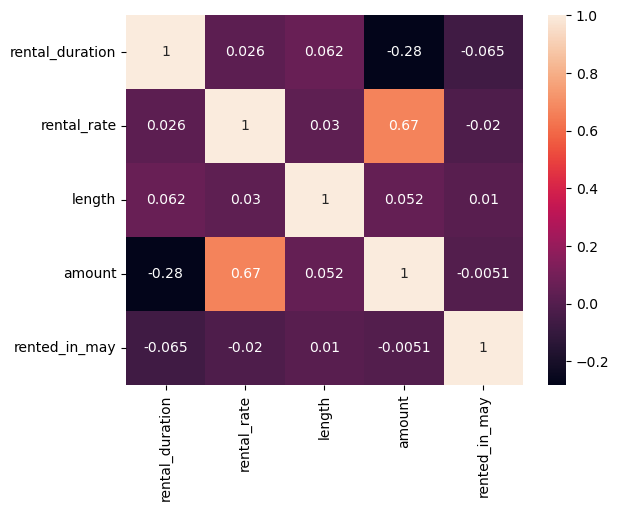

In [12]:
correlations_matrix = data.select_dtypes(include = np.number).corr()
sns.heatmap(correlations_matrix, annot=True)
plt.show()

In [13]:
y = data['rented_in_may']
X = data.drop('rented_in_may', axis=1)

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1337)

In [15]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
# from sklearn.preprocessing import StandardScaler

X_train_num = X_train.select_dtypes(include = np.number)

# Scaling data
transformer = MinMaxScaler().fit(X_train_num) # need to keep transformer
X_train_normalized = transformer.transform(X_train_num)
X_train_norm = pd.DataFrame(X_train_normalized, columns=X_train_num.columns)
X_train_norm

,rental_duration,rental_rate,length,amount
0,0.75,0.0,0.050360,0.0
1,0.50,0.0,0.000000,0.0
2,0.50,0.5,0.309353,0.5
3,0.00,1.0,0.402878,0.6
4,0.75,0.0,0.510791,0.0
...,...,...,...,...
745,0.50,0.0,0.151079,0.0
746,0.00,0.0,0.683453,0.0
747,0.00,1.0,0.467626,0.7
748,0.50,1.0,0.906475,0.8


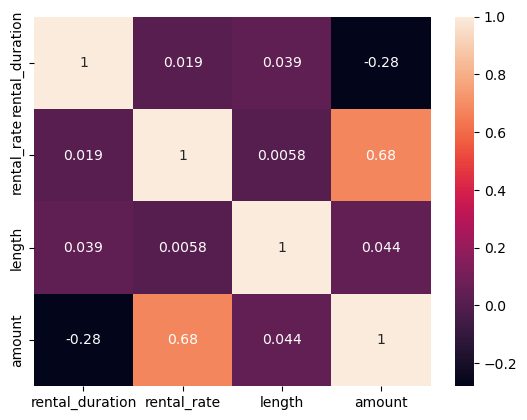

In [16]:
correlations_matrix = X_train_num.corr()
sns.heatmap(correlations_matrix, annot=True)
plt.show()

In [17]:
X_train_categorical = X_train.select_dtypes(include = object)
X_train_cat = pd.get_dummies(X_train_categorical, 
                             columns=['rating'],
                             drop_first=True)
X_train_cat

,rating_NC-17,rating_PG,rating_PG-13,rating_R
65,True,False,False,False
503,False,False,True,False
360,True,False,False,False
767,False,False,True,False
726,False,True,False,False
...,...,...,...,...
167,False,False,False,True
232,False,True,False,False
860,False,False,False,True
189,True,False,False,False


In [18]:
X_train_transformed = np.concatenate([X_train_norm, X_train_cat], axis=1)
X_train_transformed.shape

(750, 8)

In [19]:
from sklearn.linear_model import LogisticRegression
classification = LogisticRegression(random_state=0, solver='saga',
                  multi_class='multinomial').fit(X_train_transformed, y_train)

In [20]:
X_test_num = X_test.select_dtypes(include = np.number)

# Scaling data
# we use the transformer that was trained on the training data
X_test_normalized = transformer.transform(X_test_num)
X_test_norm = pd.DataFrame(X_test_normalized)
X_test_norm

,0,1,2,3
0,0.00,0.0,0.374101,0.5
1,0.75,0.5,0.964029,0.2
2,0.25,0.5,0.316547,0.2
3,1.00,0.5,0.618705,0.3
4,0.25,0.0,0.453237,0.0
...,...,...,...,...
245,1.00,1.0,0.266187,0.4
246,1.00,0.5,0.366906,0.4
247,0.50,0.5,0.971223,0.4
248,0.50,0.5,0.769784,0.3


In [21]:
X_test_categorical = X_test.select_dtypes(include = object)
X_test_cat = pd.get_dummies(X_test_categorical, 
                            columns=['rating'],
                            drop_first=True)
X_test_cat

,rating_NC-17,rating_PG,rating_PG-13,rating_R
977,False,False,False,True
15,True,False,False,False
56,False,False,True,False
801,False,True,False,False
747,False,False,True,False
...,...,...,...,...
341,False,False,False,True
539,False,False,True,False
840,False,True,False,False
32,False,False,True,False


In [22]:
list(X_train_cat.columns)==list(X_test_cat.columns)

True

In [23]:
X_test_transformed = np.concatenate([X_test_norm, X_test_cat], axis=1)
X_test_transformed.shape

(250, 8)

In [24]:
predictions = classification.predict(X_test_transformed)
classification.score(X_test_transformed, y_test)

0.704